# Image pre-processing with OpenCV to improve OCR results.

This notebook is based on [Stack Overflow question](https://stackoverflow.com/questions/33881175/remove-background-noise-from-image-to-make-text-more-clear-for-ocr) about how to remove background noise from images, to proceed into the OCR process. Sometimes when using Tesseract to OCR in images, we don’t obtain the desired results. The reason is simple, the image has a complex background, even if you’re using Page Segmentation functions from Tesseract, it cannot be enough. 

The solution for this problem is image pre-processing. We can perform it with several libraries, but in this example we consider OpenCV to clean up images with complex background. Keep in mind, each compute vision task requires different methods of pre-processing. This example was made with several trial and error.

The images used in this example come from the [Stack Overflow question](https://stackoverflow.com/questions/33881175/remove-background-noise-from-image-to-make-text-more-clear-for-ocr) and this [dataset](https://mega.nz/file/2Xo0lYxI#utIihUv511jwJXCti4g35yjhl9ogQxjc2sTkZ2BW-Aw) for break captchas models.

## Importing libraries

In [90]:
from imutils import paths
import imutils
import numpy as np
import cv2 as cv
import pytesseract as tsr
import matplotlib.pyplot as plt

## Loading the dataset

**Setting the dataset**

In [91]:
dataset = 'testFolder' # path
pathImages = list(paths.list_images(dataset)) # list of images inside the dataset
len(pathImages)

1

**Loading and visualizing the images**

Height: 3366 Width:2587


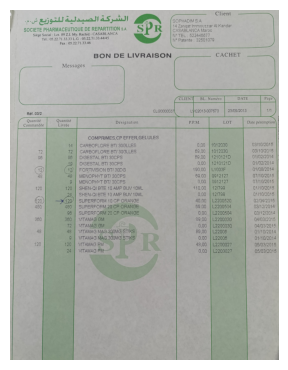

In [92]:
count = 1
plt.figure(figsize=(10,10))
for i in pathImages:
    img = cv.imread(i)
    (h, w) = img.shape[:2]
    print("Height: {} Width:{}".format(h,w))
    ax = plt.subplot(2,2,count)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    count += 1
    plt.axis('off')
plt.show()

**Resizing and storing images**

The first image pre-processing is done in this moment. All loaded images are rectangular, with the width dimension great than the height dimension. As we'll see in the remainder of this notebook, some of image operations involve kernel sliding, it's fundamental to have images with enough width or height. Otherwise, these operations can fail. It's also important to preserve a good resolution for each image. 

We resize all images along the width dimension conserving the aspect ration, this avoids distortions that can be harmful to the results. We creat a list to store the images in the array representation.

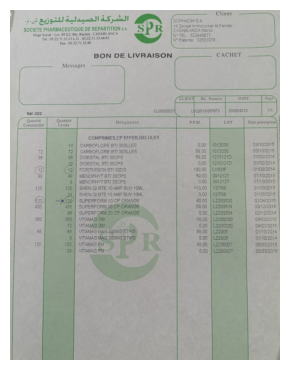

In [93]:
images = [] # empty list to store the images
count = 1
plt.figure(figsize=(10,10))
for i in pathImages:
    img = cv.imread(i) # laoding the image
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # converting into RGB order
    img = imutils.resize(img, width=500) #resizing the width into 500 pxls
    images.append(img) # adding the resized image in the list
    ax = plt.subplot(2,2,count)
    plt.imshow(img)
    count += 1
    plt.axis('off')
plt.show()

## OCR without image pre-processing

The first attempt to OCR all images is pass them directly into the function `image_to_string(img, config=config)`. We consider the Page Segmentation 8 from Tesseract `config = '--psm 8'`. This argument treats the image as a single word, in some cases it can improve the OCR results.

In [94]:
config = '--psm 8'
for i in images:
    
    text = tsr.image_to_string(i, config=config)
    print(text)

ef



**As seen in the results, there's no satisfactory results, we must pre-process the images.**

## Image pre-processing

Let's start visualizing one single image

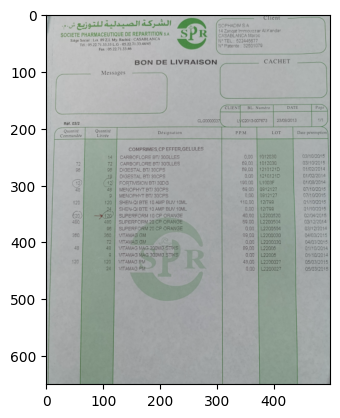

In [95]:
img = images[-1]
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

First observation, the image contains noises and the numbers don't have good resolution. The main idea is to remove all black points in the image, preserving just the numbers. To try it, we must think to image thresholding, in this way we can contrast black and white pixels.

To perform the image threshold we convert the image into the **gray scale**.

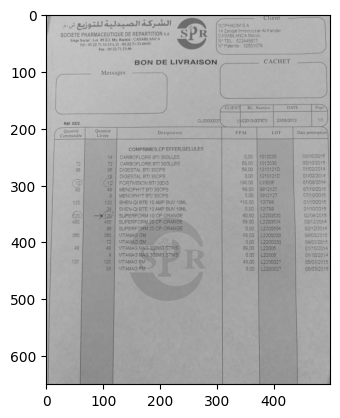

In [96]:
gray = cv.cvtColor(images[-1], cv.COLOR_RGB2GRAY)
plt.imshow(cv.cvtColor(gray, cv.COLOR_GRAY2RGB))
plt.show()

To apply the image thresholding, we consider the function [`cv.threshold()`](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57), using the [Otsu method](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html) combined with [`cv.THRESH_BINARY_INV`](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ggaa9e58d2860d4afa658ef70a9b1115576a19120b1a11d8067576cc24f4d2f03754). The inverse operation convert all black pixels into white and vice-versa. The values `0` and `255` correspond to the `thresh` and `maxval` arguments, respectivily.

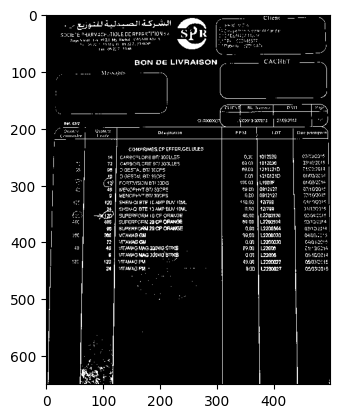

In [97]:
thresh = cv.threshold(gray, 139, 255, cv.THRESH_BINARY_INV)[1] # | cv.THRESH_OTSU
plt.imshow(cv.cvtColor(thresh, cv.COLOR_GRAY2RGB))
plt.show()

The next operation is the [distance Transform](https://docs.opencv.org/4.x/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042). From the OpenCV website "the function `cv.distanceTransform`calculates the approximate or precise distance from every binary image pixel to the nearest zero pixel. For zero image pixels, the distance will obviously be zero". This allows us to distinct the white pixels. 

The function `cv.distanceTransform` accepts some arguments as image source, the distance (in this case we consider Euclidean distance `cv.DIST_L2`) and the maskSize, that's a kernel size (we consider the value `5`).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


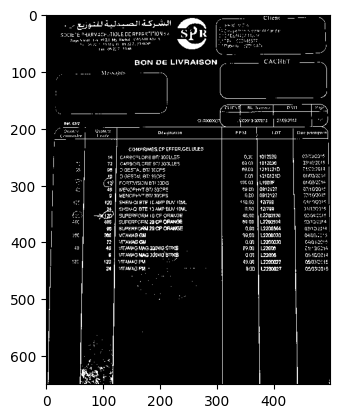

In [98]:
dist = cv.distanceTransform(thresh, cv.DIST_L2, 5)
plt.imshow(cv.cvtColor(dist, cv.COLOR_BGR2RGB))
plt.show()

After the distance operation, we normalize the pixels into a scale of $[0, 1]$, with the function `cv.normalize` and the method `cv.NORM_MINMAX`. After that, we change the pixels scale into $[0,255]$. We obtain thin number closed to the white pixels range.

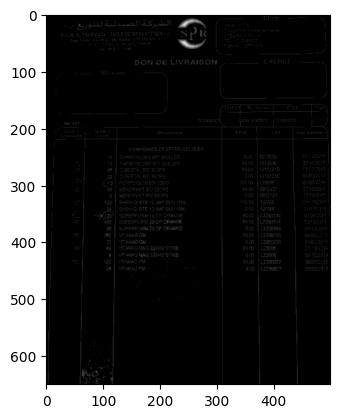

In [99]:
dist = cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
dist = (dist*255).astype('uint8')
plt.imshow(cv.cvtColor(dist, cv.COLOR_BGR2RGB))
plt.show()

Once again we apply image thresholding, but in this time, we consider `cv.THRESH_BINARY`. This mode binarizes the image according the pixels intensity.

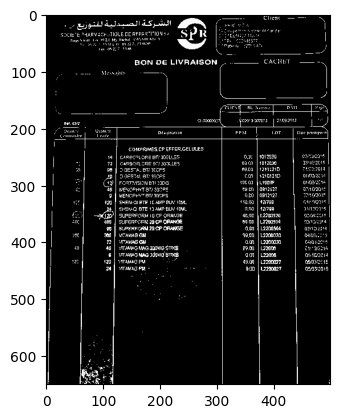

In [100]:
dist = cv.threshold(dist, 100, 250, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
plt.imshow(cv.cvtColor(dist, cv.COLOR_BGR2RGB))
plt.show()

Here, we apply [Morphology Transformation](https://docs.opencv.org/3.4/d3/dbe/tutorial_opening_closing_hats.html). To do it, we consider the function [`cv.morphologyEx()`](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga67493776e3ad1a3df63883829375201f). This function accepts some arguments, for us, the main argument will be `op`, that's the morphological operation. We consider [`cv.MORPH_OPEN`](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga7be549266bad7b2e6a04db49827f9f32), this method is useful for removing small objects (it is assumed that the objects are bright on a dark foreground). Other argument for `cv.morphologyEx` is the kernel. We consider the function [`cv.getStructuringElement`](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gac342a1bb6eabf6f55c803b09268e36dc) to build the kernel, this function requires the method and kernel size, in this case we use `cv.MORPH_CROSS`. The kernel size is $(6,6)$.

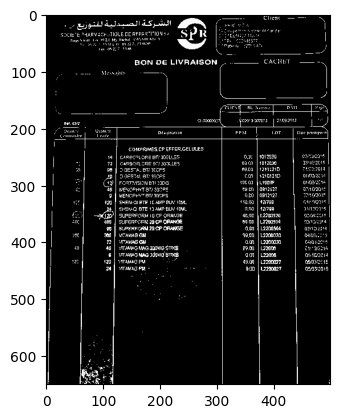

True

In [104]:
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (1,1))
opening = cv.morphologyEx(dist, cv.MORPH_OPEN, kernel)
plt.imshow(cv.cvtColor(opening, cv.COLOR_BGR2RGB))
plt.show()
cv.imwrite('final.jpg', opening)


As we can see, the morphological eliminated most of small points in the figure. To ensure a good shape for each number in the image, we consider another morphological operation. Using the function [`cv.dilate()`](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c), we obtain numbers more large. This function requires arguments as image source, kernel and iterations. The iterations argument is the number of dilations.

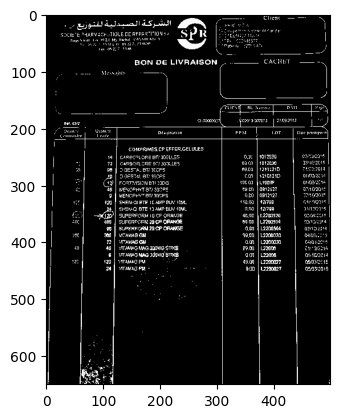

In [105]:
kernel = cv.getStructuringElement(cv.MORPH_CROSS, (1,1))
dilation = cv.dilate(opening, kernel, iterations = 1)
plt.imshow(cv.cvtColor(dilation, cv.COLOR_BGR2RGB))
plt.show()



Now, we find the contour in the image. Once we grab the contours, we filter them by the height and width.

In [69]:
cnts = cv.findContours(dilation.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
nums = []
for c in cnts:
    (x, y, w, h) = cv.boundingRect(c)
    
    if w >= 15 and h > 50:
        nums.append(c)
len(nums)

3

In this moment, we want to mask all contours found in the image. To perform it, we consider the convexHull function to draw the shape of the region of interest on the mask.

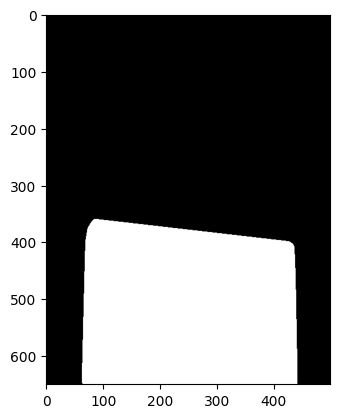

In [106]:
nums = np.vstack([nums[i] for i in range(0, len(nums))]) #converting the list into an array
hull = cv.convexHull(nums)
mask = np.zeros(dilation.shape[:2], dtype='uint8')
cv.drawContours(mask, [hull], -1, 255, -1)
mask = cv.dilate(mask, None, iterations = 2)
plt.imshow(cv.cvtColor(mask, cv.COLOR_BGR2RGB))
plt.show()

To obtain the pre-processed image, we consider the bit-wise operation using the function `cv.bitwise_and()`.

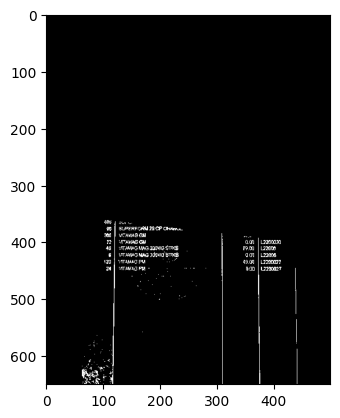

In [107]:
final = cv.bitwise_and(dilation, dilation, mask=mask)
plt.imshow(cv.cvtColor(final, cv.COLOR_BGR2RGB))
plt.show()



Given the pre-processed image, we are able to proceed with the OCR. We consider the function `image_to_string()`. The arguments that we'll use are `--psm 7` that treats the image as a single line of text and `-c` to define the white list.

In [79]:
config = "--psm 7 -c tessedit_char_whitelist=0123456789"
text = tsr.image_to_string(final, config=config)
print(text)

## OCR'ing multiple images

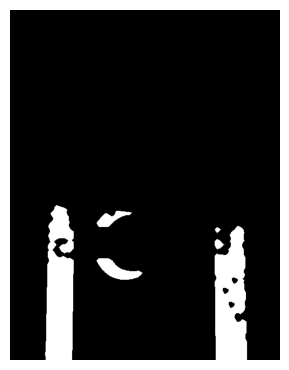

In [81]:
img_proc = []
plt.figure(figsize=(10,10))
count = 1
for i in images:
    
    gray = cv.cvtColor(i, cv.COLOR_RGB2GRAY)
    
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]
    
    dist = cv.distanceTransform(thresh, cv.DIST_L2, 5)
    dist = cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
    dist = (dist*255).astype('uint8')
    dist = cv.threshold(dist, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]
    
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (6,6))
    opening = cv.morphologyEx(dist, cv.MORPH_OPEN, kernel)
    
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (4,4))
    dilation = cv.dilate(opening, kernel, iterations = 2)
    
    cnts = cv.findContours(dilation.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    nums = []
    for c in cnts:
        (x, y, w, h) = cv.boundingRect(c)
        
        if w >= 15 and h > 50:
            nums.append(c)
    nums = np.vstack([nums[i] for i in range(0, len(nums))])
    hull = cv.convexHull(nums)
    
    mask = np.zeros(dilation.shape[:2], dtype='uint8')
    cv.drawContours(mask, [hull], -1, 255, -1)
    mask = cv.dilate(mask, None, iterations = 2)
    
    final = cv.bitwise_and(dilation, dilation, mask=mask)
    
    ax = plt.subplot(2,2,count)
    plt.imshow(cv.cvtColor(final, cv.COLOR_BGR2RGB))
    count += 1
    plt.axis('off') 
    img_proc.append(final)
    text = tsr.image_to_string(final, config=config)
    print(text)
    
plt.show()
    
    

## Conclusion

Tesseract is a powerful OCR engine. But to work well, Tesseract requires images well pre-processed. Here, we present an example of how to pre-process images. In computer vision, each task can demand different operations for image pre-processing and Tesseract arguments. As we can see, we have good results, even if there's one prediction that is note accurate. But keep in mind, all techniques and parameters used here can be changed according the problem.